## Solve LP using CVXPY

In [1]:
# get the nasdaq data from 2022-01-01 to 2023-01-01
import yfinance as yf
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

total_df = pd.DataFrame()
corr_df = pd.DataFrame()

In [2]:
def IndexTracking_LP(df, index_name, tol=1e-6):
    index_data = df[index_name].values
    portfolio_data = df.drop(['Date', index_name], axis=1).values
    
    num_days = len(index_data)
    num_stocks = portfolio_data.shape[1]
    
    weights_values = np.zeros((num_days, num_stocks))
    min_abs_diff = np.zeros(num_days)
    portfolio_index = np.zeros(num_days)
    
    for day in tqdm(range(num_days)):
        try:
            weights = cp.Variable(num_stocks)
            w = cp.Variable(1)
            
            constraints = [
                cp.sum(weights) == 1,
                weights >= 0,
                w >= tol,
                w >= index_data[day] - portfolio_data[day] @ weights + tol,
                w >= portfolio_data[day] @ weights - index_data[day] + tol
            ]
            # Define the optimization problem.
            problem = cp.Problem(cp.Minimize(w), constraints)
            problem.solve()
            
            # Save the values for plotting
            weights_values[day] = weights.value
            min_abs_diff[day] = w.value
            portfolio_index[day] = kospi_data[day] @ weights.value
        except:
            pass
    
    return weights_values, min_abs_diff, portfolio_index

### Nasdaq index tracking using kospi 200

In [3]:
# get the nasdaq data from 2022-01-01 to 2023-01-01
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime(2023, 1, 1)
nasdaq = yf.download('^IXIC', start=start, end=end, progress=False)
nasdaq = nasdaq.reset_index()
nasdaq = nasdaq[['Date', 'Adj Close']]
nasdaq.columns = ['Date', 'nasdaq']
df = nasdaq

In [4]:
# get the stock data from 2022-01-01 to 2023-01-01 in kospi 200
pdf = stock.get_index_portfolio_deposit_file("1028")
for p in tqdm(pdf):
    stock_data = stock.get_market_ohlcv_by_date("20220101", "20230101", p)
    stock_data = stock_data.reset_index()
    stock_data = stock_data[['날짜', '종가']]
    stock_data.columns = ['Date', p]
    df = pd.merge(df, stock_data, on='Date', how='left')

100%|██████████| 200/200 [02:19<00:00,  1.44it/s]


In [5]:
# nan value processing
df = df.fillna(method='ffill')
df = df.dropna(axis=1)

In [6]:
import cvxpy as cp
import numpy as np

# Assuming historical data for the Nasdaq index and the Kospi 200 stocks is in two NumPy arrays:
# nasdaq_data: shape (num_days,)
# kospi_data: shape (num_days, num_stocks)

nasdaq_data = df['nasdaq'].values
kospi_data = df.drop(['Date', 'nasdaq'], axis=1).values

num_days = len(nasdaq_data)
num_stocks = kospi_data.shape[1]

# Save the weight values, minimum absolute difference, and porfolio index for each day.
weights_values = np.zeros((num_days, num_stocks))
min_abs_diff = np.zeros(num_days)
portfolio_index = np.zeros(num_days)

# Solve the problem for each day.
for day in tqdm(range(num_days)):
    
    try:
        # Define the decision variables.
        weights = cp.Variable(num_stocks)

        # Define the objective function: minimize the absolute difference between Nasdaq and the Kospi 200 portfolio.
        # w = absolute difference
        w = cp.Variable(1)
        tol = 1e-6

        # Create the constraints.
        constraints = [
            cp.sum(weights) == 1,  # The sum of all decision variables must be 1.
            weights >= 0,          # All decision variables must be greater than 0.
            w >= tol,                # w >= 0
            w >= nasdaq_data[day] - kospi_data[day] @ weights,  # w >= Nasdaq - Kospi 200 portfolio
            w >= kospi_data[day] @ weights - nasdaq_data[day],   # w >= Kospi 200 portfolio - Nasdaq
        ]

        # Define the optimization problem.
        problem = cp.Problem(cp.Minimize(w), constraints)
        problem.solve()
        
        # Save the values for plotting
        weights_values[day] = weights.value
        min_abs_diff[day] = w.value
        portfolio_index[day] = kospi_data[day] @ weights.value
    except:
        pass


100%|██████████| 251/251 [00:00<00:00, 255.65it/s]


In [7]:
# check the correlation between nasdaq_data and kospi_data
corr = df.iloc[:,1:].corr(method='pearson')
corr_df['nasdaq'] = corr['nasdaq']

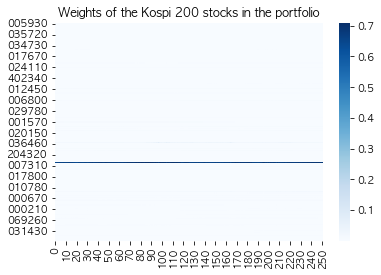

In [8]:
# plot the heatmap using mpld3
# the weights are the values in the heatmap
import seaborn as sns
import matplotlib.pyplot as plt
weights_values = pd.DataFrame(weights_values, columns=df.columns[2:])
sns.heatmap(weights_values.T, cmap='Blues')
plt.title('Weights of the Kospi 200 stocks in the portfolio')
plt.show()

# 001440 -> 대한전선?
# 대한전선 빼서 correlation
# 시각화 log 해서 잘 보내기


In [9]:
# 가장 큰 weight를 가진 주식
big_weight = weights_values.idxmax(axis=1)[0]
big_weight

'001440'

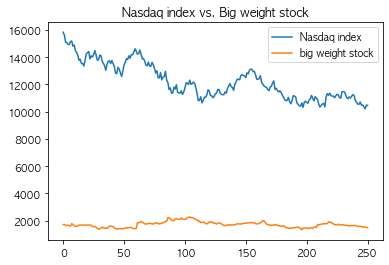

In [10]:
# plot the original index and the portfolio index
plt.plot(nasdaq_data, label='Nasdaq index')
plt.plot(df[big_weight], label='big weight stock')
plt.legend()
plt.title('Nasdaq index vs. Big weight stock')
plt.show()

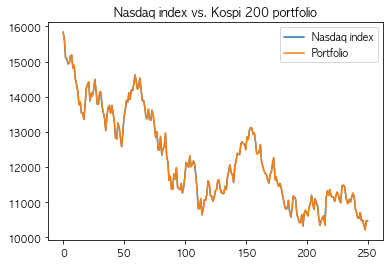

In [11]:
# plot the original index and the portfolio index
plt.plot(nasdaq_data, label='Nasdaq index')
plt.plot(portfolio_index, label='Portfolio')
plt.legend()
plt.title('Nasdaq index vs. Kospi 200 portfolio')
plt.show()

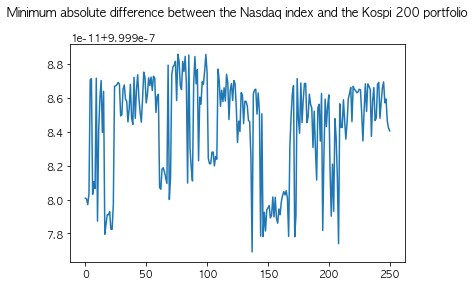

In [12]:
# plot the minimum absolute difference
plt.plot(min_abs_diff)
# title 위치 위로 올리기
plt.title('Minimum absolute difference between the Nasdaq index and the Kospi 200 portfolio', y=1.1)
plt.show()

In [13]:
# weight가 가장 큰 stock을 제외하고 포트폴리오를 구성하도록
big_stock_name = []
big_stock_weight = []
for i in range(10):
    weights_values = pd.DataFrame(weights_values, columns=df.columns[2:])
    high_weight = weights_values.idxmax(axis=1)[0] #weights_values.idxmax(axis=1)[0]
    high_average = weights_values[high_weight].mean()
    print('stock name: ', high_weight,'mean of weight: ', high_average)
    big_stock_name.append(high_weight)
    big_stock_weight.append(high_average)
    df = df.drop([high_weight], axis=1)
    weights_values, min_abs_diff, portfolio_index = IndexTracking_LP(df, 'nasdaq', tol=1e-6)
total_df['nasdaq_stock']=big_stock_name
total_df['nasdaq_weight']=big_stock_weight

stock name:  001440 mean of weight:  0.6749388984142742


100%|██████████| 251/251 [00:00<00:00, 257.38it/s]


stock name:  088350 mean of weight:  0.6978115321296721


100%|██████████| 251/251 [00:00<00:00, 254.38it/s]


stock name:  073240 mean of weight:  0.6996986348871725


100%|██████████| 251/251 [00:00<00:00, 268.58it/s]


stock name:  001740 mean of weight:  0.5597378666091553


100%|██████████| 251/251 [00:00<00:00, 276.55it/s]


stock name:  001570 mean of weight:  0.37217252021142294


100%|██████████| 251/251 [00:00<00:00, 285.72it/s]


stock name:  028670 mean of weight:  0.1240694346575268


100%|██████████| 251/251 [00:00<00:00, 258.71it/s]


stock name:  010140 mean of weight:  0.3618587121193538


100%|██████████| 251/251 [00:00<00:00, 266.66it/s]


stock name:  047040 mean of weight:  0.5577917106441357


100%|██████████| 251/251 [00:00<00:00, 271.16it/s]


stock name:  042670 mean of weight:  0.6840544979535175


100%|██████████| 251/251 [00:00<00:00, 261.37it/s]


stock name:  003410 mean of weight:  0.40494426567165226


100%|██████████| 251/251 [00:00<00:00, 260.29it/s]


### Nifty50 index tracking using kospi 200 (인도)

In [14]:
# get the Nifty50 data from 2022-01-01 to 2023-01-01
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime(2023, 1, 1)
nifty = yf.download('^NSEI', start=start, end=end, progress=False)
nifty = nifty.reset_index()
nifty = nifty[['Date', 'Adj Close']]
nifty.columns = ['Date', 'nifty']
df = nifty

In [15]:
# get the stock data from 2022-01-01 to 2023-01-01 in kospi 200
pdf = stock.get_index_portfolio_deposit_file("1028")
for p in tqdm(pdf):
    stock_data = stock.get_market_ohlcv_by_date("20220101", "20230101", p)
    stock_data = stock_data.reset_index()
    stock_data = stock_data[['날짜', '종가']]
    stock_data.columns = ['Date', p]
    df = pd.merge(df, stock_data, on='Date', how='left')

100%|██████████| 200/200 [02:12<00:00,  1.51it/s]


In [16]:
# nan value processing
df = df.fillna(method='ffill')
df = df.dropna(axis=1)

In [17]:
# Assuming historical data for the Nasdaq index and the Kospi 200 stocks is in two NumPy arrays:
# nasdaq_data: shape (num_days,)
# kospi_data: shape (num_days, num_stocks)

nasdaq_data = df['nifty'].values
kospi_data = df.drop(['Date', 'nifty'], axis=1).values

num_days = len(nasdaq_data)
num_stocks = kospi_data.shape[1]

# Save the weight values, minimum absolute difference, and porfolio index for each day.
weights_values = np.zeros((num_days, num_stocks))
min_abs_diff = np.zeros(num_days)
portfolio_index = np.zeros(num_days)

# Solve the problem for each day.
for day in tqdm(range(num_days)):
    
    try:
        # Define the decision variables.
        weights = cp.Variable(num_stocks)

        # Define the objective function: minimize the absolute difference between Nasdaq and the Kospi 200 portfolio.
        # w = absolute difference
        w = cp.Variable(1)
        tol = 1e-3

        # Create the constraints.
        constraints = [
            cp.sum(weights) == 1,  # The sum of all decision variables must be 1.
            weights >= tol,          # All decision variables must be greater than 0.
            w >= nasdaq_data[day] - kospi_data[day] @ weights,  # w >= Nasdaq - Kospi 200 portfolio
            w >= kospi_data[day] @ weights - nasdaq_data[day],   # w >= Kospi 200 portfolio - Nasdaq
            w >= 0,               # w >= 0
        ]

        # Define the optimization problem.
        problem = cp.Problem(cp.Minimize(w), constraints)
        problem.solve()
        
        # Save the values for plotting
        weights_values[day] = weights.value
        min_abs_diff[day] = w.value
        portfolio_index[day] = kospi_data[day] @ weights.value
    except:
        pass


100%|██████████| 248/248 [00:00<00:00, 277.06it/s]


In [18]:
corr = df.iloc[:,1:].corr(method='pearson')
corr_df['nifty'] = corr['nifty']

In [19]:
# check the correlation between nasdaq_data and kospi_data
corr = df.iloc[:,1:].corr(method='pearson')
corr['nifty']

nifty     1.000000
005930   -0.013161
000660   -0.239799
207940    0.411753
051910    0.707165
            ...   
003850    0.005901
013890   -0.321389
284740    0.148160
057050   -0.122246
020000   -0.469420
Name: nifty, Length: 200, dtype: float64

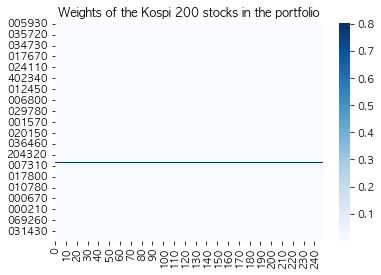

In [20]:
# plot the heatmap using mpld3
# the weights are the values in the heatmap
weights_values = pd.DataFrame(weights_values, columns=df.columns[2:])
sns.heatmap(weights_values.T, cmap='Blues')
plt.title('Weights of the Kospi 200 stocks in the portfolio')
plt.show()

In [21]:
# 가장 큰 weight를 가진 주식
big_weight = weights_values.idxmax(axis=1)[0]
big_weight

'001440'

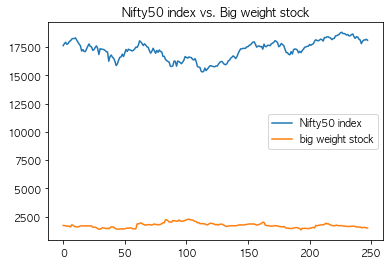

In [22]:
# plot the original index and the portfolio index
plt.plot(nasdaq_data, label='Nifty50 index')
plt.plot(df[big_weight], label='big weight stock')
plt.legend()
plt.title('Nifty50 index vs. Big weight stock')
plt.show()

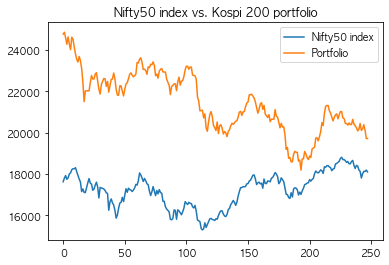

In [23]:
# plot the original index and the portfolio index
plt.plot(nasdaq_data, label='Nifty50 index')
plt.plot(portfolio_index, label='Portfolio')
plt.legend()
plt.title('Nifty50 index vs. Kospi 200 portfolio')
plt.show()

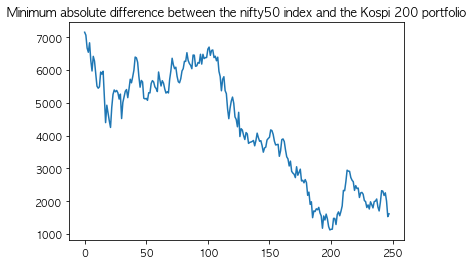

In [24]:
# plot the minimum absolute difference
plt.plot(min_abs_diff)
plt.title('Minimum absolute difference between the nifty50 index and the Kospi 200 portfolio')
plt.show()

In [25]:
# weight가 가장 큰 stock을 제외하고 포트폴리오를 구성하도록
big_stock_name = []
big_stock_weight = []
for i in range(10):
    weights_values = pd.DataFrame(weights_values, columns=df.columns[2:])
    high_weight = weights_values.idxmax(axis=1)[0] #weights_values.idxmax(axis=1)[0]
    high_average = weights_values[high_weight].mean()
    print('stock name: ', high_weight,'mean of weight: ', high_average)
    big_stock_name.append(high_weight)
    big_stock_weight.append(high_average)
    df = df.drop([high_weight], axis=1)
    weights_values, min_abs_diff, portfolio_index = IndexTracking_LP(df, 'nifty', tol=1e-6)
total_df['nifty_stock']=big_stock_name
total_df['nifty_weight']=big_stock_weight

stock name:  001440 mean of weight:  0.8019999674368171


100%|██████████| 248/248 [00:00<00:00, 278.91it/s]


stock name:  088350 mean of weight:  0.5700224042405796


100%|██████████| 248/248 [00:00<00:00, 279.83it/s]


stock name:  073240 mean of weight:  0.5571239781754708


100%|██████████| 248/248 [00:00<00:00, 280.66it/s]


stock name:  001740 mean of weight:  0.43787909789374846


100%|██████████| 248/248 [00:00<00:00, 279.51it/s]


stock name:  001570 mean of weight:  0.3255732876863486


100%|██████████| 248/248 [00:00<00:00, 269.71it/s]


stock name:  028670 mean of weight:  0.1096272378568894


100%|██████████| 248/248 [00:00<00:00, 259.55it/s]


stock name:  010140 mean of weight:  0.3208750359542754


100%|██████████| 248/248 [00:00<00:00, 256.57it/s]


stock name:  047040 mean of weight:  0.45537503637154547


100%|██████████| 248/248 [00:00<00:00, 261.20it/s]


stock name:  042670 mean of weight:  0.5902976231199417


100%|██████████| 248/248 [00:00<00:00, 256.16it/s]


stock name:  003410 mean of weight:  0.3367737302507269


100%|██████████| 248/248 [00:00<00:00, 271.02it/s]


### VN30 index tracking using kospi 200 (베트남)

In [26]:
# get the nasdaq data from 2022-01-01 to 2023-01-01
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime(2023, 1, 1)
vn100 = yf.download('245710.KS', start=start, end=end, progress=False)
vn100 = vn100.reset_index()
vn100 = vn100[['Date', 'Adj Close']]
vn100.columns = ['Date', 'vn100']
df = vn100

In [27]:
# get the stock data from 2022-01-01 to 2023-01-01 in kospi 200
pdf = stock.get_index_portfolio_deposit_file("1028")
for p in tqdm(pdf):
    stock_data = stock.get_market_ohlcv_by_date("20220101", "20230101", p)
    stock_data = stock_data.reset_index()
    stock_data = stock_data[['날짜', '종가']]
    stock_data.columns = ['Date', p]
    df = pd.merge(df, stock_data, on='Date', how='left')

100%|██████████| 200/200 [02:13<00:00,  1.50it/s]


In [28]:
# nan value processing
df = df.fillna(method='ffill')
df = df.dropna(axis=1)

In [29]:
# Assuming historical data for the Nasdaq index and the Kospi 200 stocks is in two NumPy arrays:
# nasdaq_data: shape (num_days,)
# kospi_data: shape (num_days, num_stocks)

nasdaq_data = df['vn100'].values
kospi_data = df.drop(['Date', 'vn100'], axis=1).values

num_days = len(nasdaq_data)
num_stocks = kospi_data.shape[1]

# Save the weight values, minimum absolute difference, and porfolio index for each day.
weights_values = np.zeros((num_days, num_stocks))
min_abs_diff = np.zeros(num_days)
portfolio_index = np.zeros(num_days)

# Solve the problem for each day.
for day in tqdm(range(num_days)):
    
    try:
        # Define the decision variables.
        weights = cp.Variable(num_stocks)

        # Define the objective function: minimize the absolute difference between Nasdaq and the Kospi 200 portfolio.
        # w = absolute difference
        w = cp.Variable(1)
        tol = 1e-3

        # Create the constraints.
        constraints = [
            cp.sum(weights) == 1,  # The sum of all decision variables must be 1.
            weights >= tol,          # All decision variables must be greater than 0.
            w >= nasdaq_data[day] - kospi_data[day] @ weights,  # w >= Nasdaq - Kospi 200 portfolio
            w >= kospi_data[day] @ weights - nasdaq_data[day],   # w >= Kospi 200 portfolio - Nasdaq
            w >= 0,               # w >= 0
        ]

        # Define the optimization problem.
        problem = cp.Problem(cp.Minimize(w), constraints)
        problem.solve()
        
        # Save the values for plotting
        weights_values[day] = weights.value
        min_abs_diff[day] = w.value
        portfolio_index[day] = kospi_data[day] @ weights.value
    except:
        pass


100%|██████████| 242/242 [00:00<00:00, 274.70it/s]


In [30]:
corr = df.iloc[:,1:].corr(method='pearson')
corr_df['vn100'] = corr['vn100']

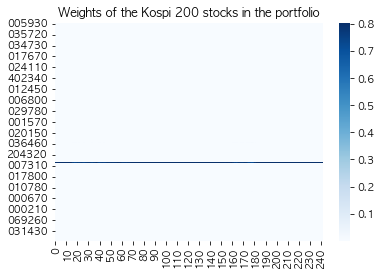

In [31]:
# plot the heatmap using mpld3
# the weights are the values in the heatmap
weights_values = pd.DataFrame(weights_values, columns=df.columns[2:])
sns.heatmap(weights_values.T, cmap='Blues')
plt.title('Weights of the Kospi 200 stocks in the portfolio')
plt.show()

# 001440 -> 대한전선?


In [32]:
# 가장 큰 weight를 가진 주식
big_weight = weights_values.idxmax(axis=1)[0]
big_weight

'001440'

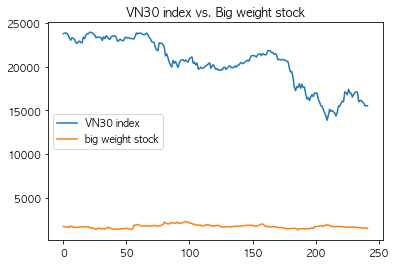

In [33]:
# plot the original index and the portfolio index
plt.plot(nasdaq_data, label='VN30 index')
plt.plot(df[big_weight], label='big weight stock')
plt.legend()
plt.title('VN30 index vs. Big weight stock')
plt.show()

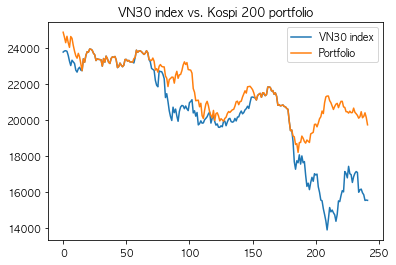

In [34]:
# plot the original index and the portfolio index
plt.plot(nasdaq_data, label='VN30 index')
plt.plot(portfolio_index, label='Portfolio')
plt.legend()
plt.title('VN30 index vs. Kospi 200 portfolio')
plt.show()

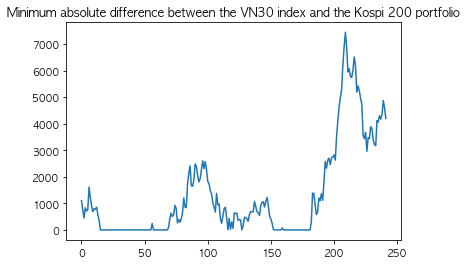

In [35]:
# plot the minimum absolute difference
plt.plot(min_abs_diff)
plt.title('Minimum absolute difference between the VN30 index and the Kospi 200 portfolio')
plt.show()

In [36]:
# weight가 가장 큰 stock을 제외하고 포트폴리오를 구성하도록
big_stock_name = []
big_stock_weight = []
for i in range(10):
    weights_values = pd.DataFrame(weights_values, columns=df.columns[2:])
    high_weight = weights_values.idxmax(axis=1)[0] #weights_values.idxmax(axis=1)[0]
    high_average = weights_values[high_weight].mean()
    print('stock name: ', high_weight,'mean of weight: ', high_average)
    big_stock_name.append(high_weight)
    big_stock_weight.append(high_average)
    df = df.drop([high_weight], axis=1)
    weights_values, min_abs_diff, portfolio_index = IndexTracking_LP(df, 'vn100', tol=1e-6)
total_df['vn100_stock']=big_stock_name
total_df['vn100_weight']=big_stock_weight

stock name:  001440 mean of weight:  0.7902984996710621


100%|██████████| 242/242 [00:00<00:00, 280.46it/s]


stock name:  088350 mean of weight:  0.49232020382996233


100%|██████████| 242/242 [00:00<00:00, 274.73it/s]


stock name:  073240 mean of weight:  0.4711921302986737


100%|██████████| 242/242 [00:00<00:00, 282.46it/s]


stock name:  001740 mean of weight:  0.3854556038533409


100%|██████████| 242/242 [00:00<00:00, 285.99it/s]


stock name:  001570 mean of weight:  0.24867676312884898


100%|██████████| 242/242 [00:00<00:00, 275.42it/s]


stock name:  028670 mean of weight:  0.09206673659101941


100%|██████████| 242/242 [00:00<00:00, 270.69it/s]


stock name:  010140 mean of weight:  0.2472474691068155


100%|██████████| 242/242 [00:00<00:00, 275.21it/s]


stock name:  047040 mean of weight:  0.4103187266870223


100%|██████████| 242/242 [00:00<00:00, 271.08it/s]


stock name:  042670 mean of weight:  0.49404888081608395


100%|██████████| 242/242 [00:00<00:00, 265.27it/s]


stock name:  003410 mean of weight:  0.3131300696937243


100%|██████████| 242/242 [00:00<00:00, 266.67it/s]


### bitcoin index tracking using kospi 200

In [37]:
# get the nasdaq data from 2022-01-01 to 2023-01-01
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime(2023, 1, 1)
bitcoin = yf.download('BTC-USD', start=start, end=end, progress=False)
bitcoin = bitcoin.reset_index()
bitcoin = bitcoin[['Date', 'Adj Close']]
bitcoin.columns = ['Date', 'bitcoin']
df = bitcoin

In [38]:
# get the stock data from 2022-01-01 to 2023-01-01 in kospi 200
pdf = stock.get_index_portfolio_deposit_file("1028")
for p in tqdm(pdf):
    stock_data = stock.get_market_ohlcv_by_date("20220101", "20230101", p)
    stock_data = stock_data.reset_index()
    stock_data = stock_data[['날짜', '종가']]
    stock_data.columns = ['Date', p]
    df = pd.merge(df, stock_data, on='Date', how='left')

100%|██████████| 200/200 [02:19<00:00,  1.44it/s]


In [39]:
# nan value processing
df = df.fillna(method='ffill')
df = df.drop(['373220'], axis=1)
df = df.dropna()

In [40]:
# Assuming historical data for the Nasdaq index and the Kospi 200 stocks is in two NumPy arrays:
# nasdaq_data: shape (num_days,)
# kospi_data: shape (num_days, num_stocks)

nasdaq_data = df['bitcoin'].values
kospi_data = df.drop(['Date', 'bitcoin'], axis=1).values

num_days = len(nasdaq_data)
num_stocks = kospi_data.shape[1]

# Save the weight values, minimum absolute difference, and porfolio index for each day.
weights_values = np.zeros((num_days, num_stocks))
min_abs_diff = np.zeros(num_days)
portfolio_index = np.zeros(num_days)

# Solve the problem for each day.
for day in tqdm(range(num_days)):
    
    try:
        # Define the decision variables.
        weights = cp.Variable(num_stocks)

        # Define the objective function: minimize the absolute difference between Nasdaq and the Kospi 200 portfolio.
        # w = absolute difference
        w = cp.Variable(1)
        tol = 1e-3

        # Create the constraints.
        constraints = [
            cp.sum(weights) == 1,  # The sum of all decision variables must be 1.
            weights >= tol,          # All decision variables must be greater than 0.
            w >= nasdaq_data[day] - kospi_data[day] @ weights,  # w >= Nasdaq - Kospi 200 portfolio
            w >= kospi_data[day] @ weights - nasdaq_data[day],   # w >= Kospi 200 portfolio - Nasdaq
            w >= 0,               # w >= 0
        ]

        # Define the optimization problem.
        problem = cp.Problem(cp.Minimize(w), constraints)
        problem.solve()
        
        # Save the values for plotting
        weights_values[day] = weights.value
        min_abs_diff[day] = w.value
        portfolio_index[day] = kospi_data[day] @ weights.value
    except:
        pass


100%|██████████| 363/363 [00:01<00:00, 271.04it/s]


In [41]:
corr = df.iloc[:,1:].corr(method='pearson')
corr_df['bitcoin'] = corr['bitcoin']

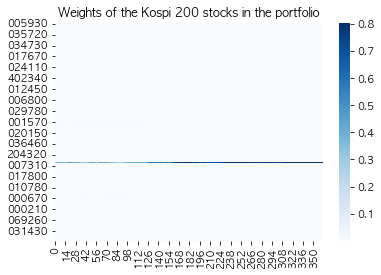

In [42]:
# plot the heatmap using mpld3
# the weights are the values in the heatmap
weights_values = pd.DataFrame(weights_values, columns=df.columns[2:])
sns.heatmap(weights_values.T, cmap='Blues')
plt.title('Weights of the Kospi 200 stocks in the portfolio')
plt.show()

# 001440 -> 대한전선?


In [43]:
# 가장 큰 weight를 가진 주식
big_weight = weights_values.idxmax(axis=1)[0]
big_weight

'001440'

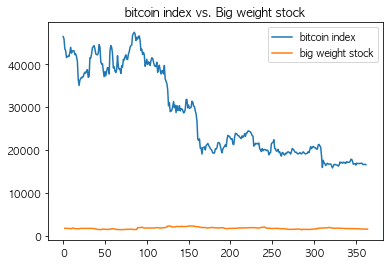

In [44]:
# plot the original index and the portfolio index
plt.plot(nasdaq_data, label='bitcoin index')
plt.plot(df[big_weight], label='big weight stock')
plt.legend()
plt.title('bitcoin index vs. Big weight stock')
plt.show()

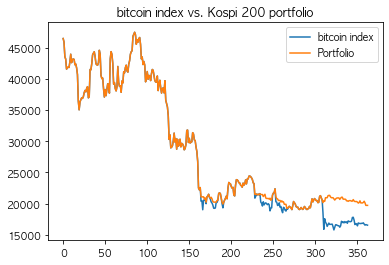

In [45]:
# plot the original index and the portfolio index
plt.plot(nasdaq_data, label='bitcoin index')
plt.plot(portfolio_index, label='Portfolio')
plt.legend()
plt.title('bitcoin index vs. Kospi 200 portfolio')
plt.show()

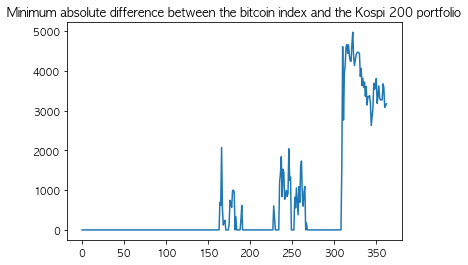

In [46]:
# plot the minimum absolute difference
plt.plot(min_abs_diff)
plt.title('Minimum absolute difference between the bitcoin index and the Kospi 200 portfolio')
plt.show()

In [47]:
# weight가 가장 큰 stock을 제외하고 포트폴리오를 구성하도록
big_stock_name = []
big_stock_weight = []
for i in range(10):
    weights_values = pd.DataFrame(weights_values, columns=df.columns[2:])
    high_weight = weights_values.idxmax(axis=1)[0] #weights_values.idxmax(axis=1)[0]
    high_average = weights_values[high_weight].mean()
    print('stock name: ', high_weight,'mean of weight: ', high_average)
    big_stock_name.append(high_weight)
    big_stock_weight.append(high_average)
    df = df.drop([high_weight], axis=1)
    weights_values, min_abs_diff, portfolio_index = IndexTracking_LP(df, 'bitcoin', tol=1e-6)
total_df['bitcoin_stock']=big_stock_name
total_df['bitcoin_weight']=big_stock_weight

stock name:  001440 mean of weight:  0.6168706237589605


100%|██████████| 363/363 [00:01<00:00, 267.30it/s]


stock name:  088350 mean of weight:  0.34904155343223714


100%|██████████| 363/363 [00:01<00:00, 269.29it/s]


stock name:  073240 mean of weight:  0.32714284651259945


100%|██████████| 363/363 [00:01<00:00, 271.01it/s]


stock name:  001740 mean of weight:  0.2937676219748745


100%|██████████| 363/363 [00:01<00:00, 275.62it/s]


stock name:  001570 mean of weight:  0.11135654306307385


100%|██████████| 363/363 [00:01<00:00, 275.70it/s]


stock name:  028670 mean of weight:  0.06051115079286718


100%|██████████| 363/363 [00:01<00:00, 277.00it/s]


stock name:  010140 mean of weight:  0.09413445690603543


100%|██████████| 363/363 [00:01<00:00, 276.93it/s]


stock name:  047040 mean of weight:  0.3041944401928303


100%|██████████| 363/363 [00:01<00:00, 277.53it/s]


stock name:  042670 mean of weight:  0.298911816295563


100%|██████████| 363/363 [00:01<00:00, 275.22it/s]


stock name:  003410 mean of weight:  0.21393983971171432


100%|██████████| 363/363 [00:01<00:00, 277.52it/s]


In [48]:
total_df

,nasdaq_stock,nasdaq_weight,nifty_stock,nifty_weight,vn100_stock,vn100_weight,bitcoin_stock,bitcoin_weight
0,001440,0.674939,001440,0.802000,001440,0.790298,001440,0.616871
1,088350,0.697812,088350,0.570022,088350,0.492320,088350,0.349042
2,073240,0.699699,073240,0.557124,073240,0.471192,073240,0.327143
3,001740,0.559738,001740,0.437879,001740,0.385456,001740,0.293768
4,001570,0.372173,001570,0.325573,001570,0.248677,001570,0.111357
5,028670,0.124069,028670,0.109627,028670,0.092067,028670,0.060511
6,010140,0.361859,010140,0.320875,010140,0.247247,010140,0.094134
7,047040,0.557792,047040,0.455375,047040,0.410319,047040,0.304194
8,042670,0.684054,042670,0.590298,042670,0.494049,042670,0.298912
9,003410,0.404944,003410,0.336774,003410,0.313130,003410,0.213940


In [49]:
weight_df = total_df[['nasdaq_weight', 'nifty_weight', 'vn100_weight', 'bitcoin_weight']]
weight_df.columns = ['nasdaq', 'nifty', 'vn100', 'bitcoin']
weight_df.index = total_df['nasdaq_stock'].values

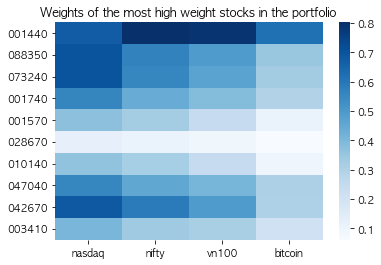

In [50]:
# make a heatmap using total_df
sns.heatmap(weight_df, cmap='Blues')
plt.title('Weights of the most high weight stocks in the portfolio')
plt.show()

,nasdaq,nifty,vn100,bitcoin
nasdaq,1.000000,NaN,NaN,NaN
005930,0.860382,-0.013161,0.654166,0.889774
000660,0.864473,-0.239799,0.813074,0.927887
207940,-0.242879,0.411753,-0.563623,-0.426307
051910,-0.024439,0.707165,-0.394953,-0.298576
...,...,...,...,...
003850,0.858776,0.005901,0.717047,0.920562
013890,0.841477,-0.321389,0.845880,0.934545
284740,0.839851,0.148160,0.643511,0.854270
057050,0.779879,-0.122246,0.710399,0.855180


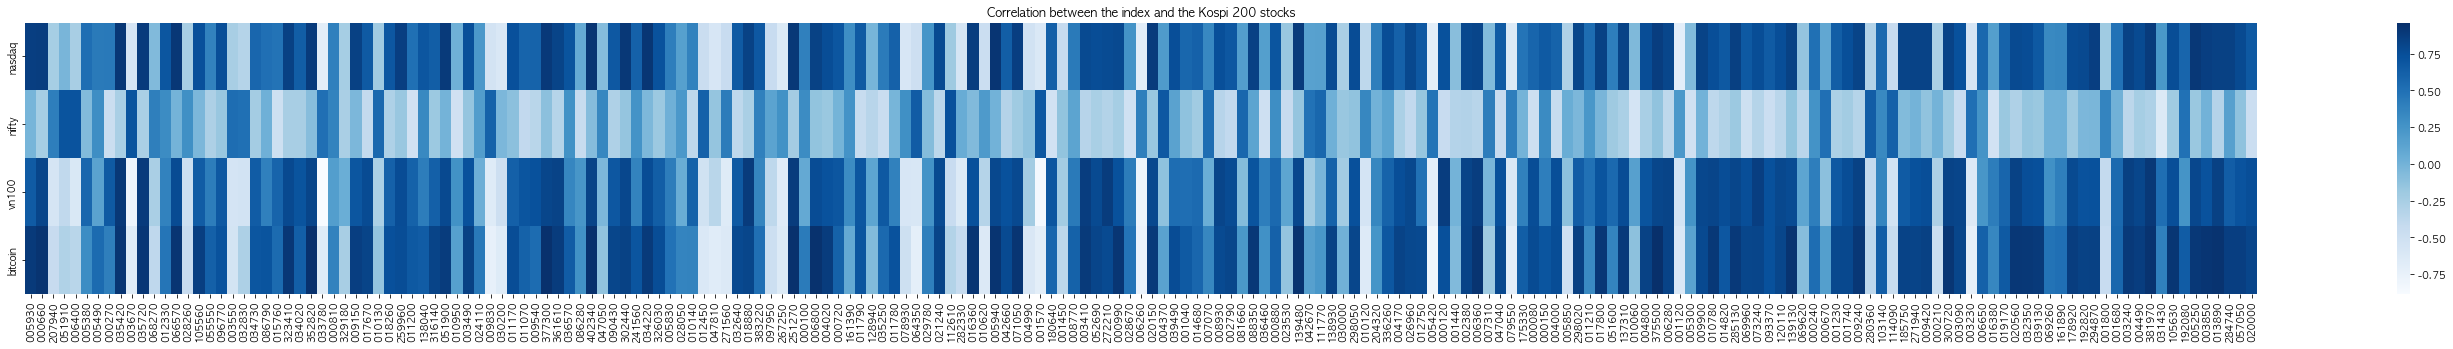

In [57]:
plt.figure(figsize=(50,5))
sns.heatmap(corr_df.iloc[1:,:].T, cmap='Blues')
plt.title('Correlation between the index and the Kospi 200 stocks')
plt.show()